## Project.6 Отток клиентов

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.


### Описание данных

#### Признаки
RowNumber — индекс строки в данных  

CustomerId — уникальный идентификатор клиента  

Surname — фамилия  

CreditScore — кредитный рейтинг  

Geography — страна проживания  

Gender — пол  

Age — возраст  

Tenure — сколько лет человек является клиентом банка  

Balance — баланс на счёте  

NumOfProducts — количество продуктов банка, используемых клиентом  

HasCrCard — наличие кредитной карты  

IsActiveMember — активность клиента  

EstimatedSalary — предполагаемая зарплата  

#### Целевой признак
Exited — факт ухода клиента


### Инструкция по выполнению проекта
Загрузите и подготовьте данные. Поясните порядок действий.  

Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.  

Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.  

Проведите финальное тестирование.

### Шаг 1. Подготовка данных

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

RANDOM_STATE = 42
#class_weight = 'balanced'
#class_weight = {0: 1, 1: 1.2},
PATH = 'datasets/Churn.csv'

In [4]:
# считаем данные файла:
df = pd.read_csv(PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Посмотрим на данные:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### Промежуточные данные:

    - Пустые значения есть у признака Tenure (скорее всего означает ее отсутствие)
    - Также признак Tenure стоит привести к целочисленному типу
    - Столбцы RowNumber, Surname и CustomerId  - неинформативны и не понадобятся, поэтому  просто удалим их.
    - Категориальные признаки Gender и Geography нужно будет преобразовать к числовым значениям

In [6]:
# Удалим ненужные признаки
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

In [7]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [8]:
# приведем названия признаков к единому регистру:
df.columns = df.columns.str.lower()

In [9]:
# взглянем на значения признака tenure:
sorted(df['tenure'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

In [10]:
# Оценим пропуски: менее 10%
df['tenure'].isna().sum()

909

In [11]:
# как вариант #1 - можно просто удалить (лучший вариант!)
df.dropna(subset=['tenure'], inplace=True)
df['tenure'] = df['tenure'].astype('int')
df['tenure'].isna().sum()

0

<div class='alert alert-warning'>⚠️ 
    Применения аргумента inplace лучше избегать, так как разработчики в новых версиях Pandas прекратят его поддержку. Параметр считается бесполезным с точки зрения производительности (под капотом все равно создает копию, которая сразу присваивается объекту) и удобства, так как не поддерживает цепочки операций (подробнее можешь прочитать здесь https://www.dataschool.io/future-of-pandas/#inplace)
</div>

In [12]:
# вариант №2: Заполним пропущенные значения Tenure  =0 не (в итоге - хуже метрики F1)
df['tenure'].fillna(0, inplace=True)  #  
#надо будет перепроверить!
df['tenure'] = df['tenure'].astype('int')

#### Обработка категориальных признаков

In [13]:
# Проверим признак Gender на варианты полов: кстати, 
# тут также присутствует легкий дисбаланс классов
df['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

In [14]:
# Посмотрим сколько у нас стран и какие:
df['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

In [15]:
# Для категориальных признаков 'geography' и 'gender' сделаем декодирование по алгоритму OHE
df_new = pd.get_dummies(df, drop_first=True)
df_new

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2,0.00,2,0,0,167773.55,0,0,0,0
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0


In [16]:
# проверим датасет на дубликаты:
df_new.duplicated().sum()

0

In [17]:
# Выделим фитчи для обучения и таргет
features = df_new.drop('exited', axis=1)
target = df_new['exited']

In [18]:
# оценим баланс классов таргета:
# сильный дисбаланс классов на лицо: учтем это в дальнейшем.
target.value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

In [19]:
df_new.to_csv("df_new.csv")

#### Промежуточный вывод  

Мы ознакомились с данными, к ним особых претензий нет, пропуски обработали, дубликатов нет, данные готовы к дальнейшей работе для обучения модели.  
При этом отметим, что таргет - сильно дисбалансирован (это надо будет учесть при построении модели, если мы хотим хороший результат).

### 2. Построение моделей, исследование результатов. 

#### Разделение данных на выборки: train, validate, test

In [20]:
# Разобьем данные на 3 части в соотношении 80%-10%-10% 
train, validate, test = \
              np.split(df_new.sample(frac=1, random_state=RANDOM_STATE),
                       [int(.8*len(df)), int(.9*len(df))])

In [21]:
#Проверим баланс разбивки в итоге:
print(train.shape,validate.shape,test.shape)

(7272, 12) (909, 12) (910, 12)


In [22]:
# for train:
train_features = train.drop(['exited'], axis=1)
train_target = train['exited']
# for validate:
validate_features = validate.drop(['exited'], axis=1)
validate_target = validate['exited']
# for test:
test_features = test.drop(['exited'], axis=1)
test_target = test['exited']

In [23]:
# print(classification_report(valid_target, valid_predicted_tree, target_names = labels)) 

### Масштабирование признаков

In [24]:
train_features.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'geography_Germany',
       'geography_Spain', 'gender_Male'],
      dtype='object')

In [25]:
# будем пробовать разные варианты стандартизации в поисках лучшего:
scaler = MinMaxScaler()
scaler = Normalizer()
scaler = MaxAbsScaler ()
scaler = StandardScaler() # самый лучший  вариант (по метрике F1)

In [26]:
# Масштабируем только числовые признаки:
numeric = ['creditscore', 'age', 'tenure',
           'balance', 'numofproducts', 'estimatedsalary']

scaler.fit(train_features[numeric])

pd.set_option('mode.chained_assignment', None)
train_features[numeric] = scaler.transform(train_features[numeric])
validate_features[numeric] = scaler.transform(validate_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

# посмотрим на тренировочной выборке что получилось
train_features

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
3639,0.294974,0.855191,1.042601,0.616832,-0.914778,1,0,0.677712,1,0,0
2835,0.014585,-0.375516,0.350737,0.641783,0.807715,1,1,-1.322093,0,1,1
3378,-1.273130,3.127266,0.004805,0.279879,-0.914778,1,1,-0.374318,1,0,1
1477,1.291914,-0.186176,-1.032992,-1.239135,-0.914778,0,1,-1.595186,0,0,1
4919,0.315744,1.044531,1.734465,0.825195,-0.914778,1,1,0.033000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
711,-0.182726,-0.375516,0.350737,0.635432,-0.914778,1,0,0.511883,1,0,1
6698,0.762290,-0.754195,0.350737,-1.239135,-0.914778,0,0,-0.674549,0,0,0
348,0.024969,-0.659525,-1.378924,0.607085,-0.914778,1,1,0.445824,1,0,0
9275,-2.332379,0.287173,-1.378924,-0.018947,-0.914778,1,1,-0.747639,1,0,1


<div class='alert alert-warning'>⚠️Приглушенное предупреждение вылетает из-за проблемы возможной модификации первоисточника данных после изменения срезов. Чтобы побороть, явно задавай копии данных при сплите (https://zen.yandex.ru/media/id/5ee6f73b7cadb75a66e4c7e3/otkuda-voznikaet-samoe-rasprostranennoe-preduprejdenie-pandas-i-kak-ego-oboiti-62727adcaa0a703436f08b72)

</div>

### Промежуточный вывод

- Мы изучили данные, заполнили пропуски, привели типы к соответствующим значениям
- Удалили признаки, которые нам вряд ли бы чем-то помогли
- Посредством One-Hot Encoding преобразовали категориальные признаки в числовые
 - Привели числовые признаки к одному масштабу

 По итогу, мы подготовили данные для дальнейшего исследования

### 2. Исследование задачи

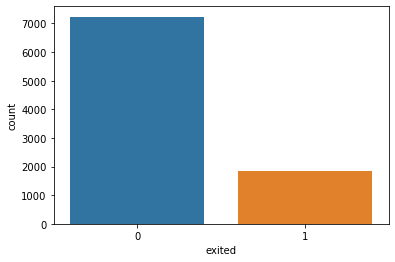

In [27]:
# Посмотрим на распределение значений целевого признака: налицо сильный дисбаланс классов!
sns.countplot(x=target)
plt.show()

Очевидно, что имеем существенный перекос в данных в пользу тех, кто еще не прекратил отношения с банком. Для нашей модели это может быть проблемой, но пока попробуем поработать с тем, что есть.

In [28]:
# Для облегчения расчета и вывода метрик при обучении моделей, напишем функцию:


def print_full_scrore_info_title():
    """
    функция расчитывает и выводит основные метрики модели на база предсказанных данных
    """
    print('|{: >9}|{: >9}|{: >9}|{: >9}|{: >9}|{: >7}|{: >7}|{: >7}|{: >7}|'.
          format('Accuracy', 'Recall', 'Precision', 'F1', 'ROC-AUC', 'TP',
                 'TN', 'FP', 'FN'))


def print_full_score_info(target, predicted, predicted_proba):
    accuracy = accuracy_score(target, predicted)
    recall = recall_score(target, predicted)
    precision = precision_score(target, predicted)
    f1 = f1_score(target, predicted)
    #roc_auc = roc_auc_score(target, predicted)
    roc_auc = roc_auc_score(target, predicted_proba[:, 1])

    confusion_m = confusion_matrix(target, predicted)
    TN = confusion_m[0][0]
    TP = confusion_m[1][1]
    FN = confusion_m[0][1]
    FP = confusion_m[1][0]

    print(
        '|{: >9.7f}|{: >9.7f}|{: >9.7f}|{: >9.7f}|{: >9.7f}|{: >7}|{: >7}|{: >7}|{: >7}|'
        .format(accuracy, recall, precision, f1, roc_auc, TP, FP, TN, FN))
    print()
    print(classification_report(target, predicted))
    print()

### Построение модели с дисбалансом классов  таргета (без обработки)

In [29]:
validate_target.value_counts()

0    718
1    191
Name: exited, dtype: int64

In [30]:
# Начнем с модели дерева решений:

# создадим массив, где будут наши лучшие результаты:
best_results = {}
best_results['decision_tree'] = {}


def check_decision_tree(train_features, train_target, class_weight,
                        train_type):
    """
    функцию по выводу информации по модели Decision tree
    """
    print('Decision tree')
    print('|{: >9}'.format('max_depth'), end='')
    print_full_scrore_info_title()

    # будем сразу считать лучшую меру и параметры, чтобы не искать глазами
    best_f1 = 0
    best_max_depth = 0
    for max_depth in range(2, 15, 1):
        model = DecisionTreeClassifier(max_depth=max_depth,
                                       random_state=RANDOM_STATE,
                                       class_weight=class_weight)
        model.fit(train_features, train_target)
        predicted_val = model.predict(validate_features)
        predicted_proba = model.predict_proba(validate_features)
        print('|{: >9}'.format(max_depth), end='')
        print_full_score_info(validate_target, predicted_val, predicted_proba)

        current_f1 = f1_score(validate_target, predicted_val)
        if (current_f1 > best_f1):
            best_f1 = current_f1
            best_max_depth = max_depth

    # воспользуемся тем, что питон будет искать наш словарь глобально
    best_results['decision_tree'][train_type] = dict()
    best_results['decision_tree'][train_type]['params'] = 'max_depth=' + str(
        best_max_depth)
    best_results['decision_tree'][train_type]['f1'] = best_f1

In [31]:
# исследуем модель дерево решений:
check_decision_tree(train_features, train_target, None, 'default')

Decision tree
|max_depth| Accuracy|   Recall|Precision|       F1|  ROC-AUC|     TP|     TN|     FP|     FN|
|        2|0.8272827|0.4712042|0.6164384|0.5341246|0.7303373|     90|    101|    662|     56|

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       718
           1       0.62      0.47      0.53       191

    accuracy                           0.83       909
   macro avg       0.74      0.70      0.71       909
weighted avg       0.81      0.83      0.82       909


|        3|0.8261826|0.2565445|0.7538462|0.3828125|0.7875133|     49|    142|    702|     16|

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       718
           1       0.75      0.26      0.38       191

    accuracy                           0.83       909
   macro avg       0.79      0.62      0.64       909
weighted avg       0.82      0.83      0.79       909


|        4|0.8536854|0.4345550|0.7685185|0.555

In [32]:
  # выведем инфо модели с лучшими настройками гиперпараметров по метрике F1:
best_results['decision_tree']

{'default': {'params': 'max_depth=9', 'f1': 0.6006006006006006}}

Нам важна точноть выявления значений "1" класса, поэтому будем смотреть на Recall, F1 и ROC-AUC:  

- хоть мы и добились f1 =0.60, однако полнота выявления "1"  у нас чуть больше 52,3%, а это не очень хорошо.

In [33]:
# исследуем модель случайный лес:

best_results['random_forest'] = {}


def check_random_forest(train_features, train_target, class_weight,
                        train_type):
    print('random_forest')
    print('|{: >12}|{: >9}|'.format('n_estimators', 'max_depth'), end='')
    print_full_scrore_info_title()
    print()

    # будем сразу считать лучшую меру и параметры, чтобы не искать глазами
    best_f1 = 0
    best_max_depth = 0
    best_n_estimators = 0

    for estim in range(5, 50, 5):
        for max_depth in range(6, 12):
            model = RandomForestClassifier(n_estimators=estim,
                                           max_depth=max_depth,
                                           random_state=RANDOM_STATE,
                                           class_weight=class_weight)
            model.fit(train_features, train_target)
            predicted_valid = model.predict(validate_features)
            predicted_proba = model.predict_proba(validate_features)
            print('|{: >12}|{: >9}|'.format(estim, max_depth), end='')
            print_full_score_info(
                validate_target, predicted_valid, predicted_proba)

            f1 = f1_score(validate_target, predicted_valid)
            if (f1 > best_f1):
                best_f1 = f1
                best_max_depth = max_depth
                best_n_estimators = estim

        print()  # для разделения вывода по количеству деревьев

    # воспользуемся тем, что питон будет искать наш словарь глобально
    best_results['random_forest'][train_type] = dict()
    best_results['random_forest'][train_type]['params'] = 'estim=' + str(
        best_n_estimators) + '; max_depth=' + str(best_max_depth)
    best_results['random_forest'][train_type]['f1'] = best_f1


check_random_forest(train_features, train_target, None, 'default')

random_forest
|n_estimators|max_depth|| Accuracy|   Recall|Precision|       F1|  ROC-AUC|     TP|     TN|     FP|     FN|

|           5|        6||0.8503850|0.3769634|0.8089888|0.5142857|0.8343493|     72|    119|    701|     17|

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       718
           1       0.81      0.38      0.51       191

    accuracy                           0.85       909
   macro avg       0.83      0.68      0.71       909
weighted avg       0.85      0.85      0.83       909


|           5|        7||0.8492849|0.3979058|0.7755102|0.5259516|0.8346592|     76|    115|    696|     22|

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       718
           1       0.78      0.40      0.53       191

    accuracy                           0.85       909
   macro avg       0.82      0.68      0.72       909
weighted avg       0.84      0.85      0.83       909


|  

In [34]:
# лучшие настройки модели и лучший результат:
best_results['random_forest']

{'default': {'params': 'estim=40; max_depth=11', 'f1': 0.6038961038961039}}

Нам важна точноть выявления значений "1" класса, поэтому будем смотреть на Recall, F1 и ROC-AUC:
- хоть мы и добились f1 =0.599, однако полнота выявления "1"  у нас чуть больше 48%, а это не очень хорошо.

In [35]:
# Посмотрим на модель регрессию:

best_results['logistic_regression'] = {}


def check_logistic_regression(train_features, train_target, class_weight,
                              train_type):
    print('Logistic regression')
    print_full_scrore_info_title()

    model = LogisticRegression(solver='liblinear',
                               random_state=RANDOM_STATE,
                               class_weight=class_weight)
    model.fit(train_features, train_target)
    predicted_valid = model.predict(validate_features)
    predicted_proba = model.predict_proba(validate_features)
    print_full_score_info(validate_target, predicted_valid, predicted_proba)

    # воспользуемся тем, что питон будет искать наш словарь глобально
    best_results['logistic_regression'][train_type] = dict()
    best_results['logistic_regression'][train_type]['params'] = '-'
    best_results['logistic_regression'][train_type]['f1'] = f1_score(
        validate_target, predicted_valid)


check_logistic_regression(train_features, train_target, None, 'default')

Logistic regression
| Accuracy|   Recall|Precision|       F1|  ROC-AUC|     TP|     TN|     FP|     FN|
|0.8074807|0.2251309|0.6142857|0.3295019|0.7638146|     43|    148|    691|     27|

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       718
           1       0.61      0.23      0.33       191

    accuracy                           0.81       909
   macro avg       0.72      0.59      0.61       909
weighted avg       0.78      0.81      0.77       909




Нам важна точноть выявления значений "1" класса, поэтому будем смотреть на Recall, F1 и ROC-AUC:  

- тут низкое и  f1 =0.33, и полнота выявления "1"  у нас чуть больше 22,5%, а это совсем плохо (лучше уж монетку бросать).

In [36]:
# модель CatBoostClassifier:

best_results['catboost_model'] = {}


def model_catboost_classifier(train_features, train_target, class_weight,
                              train_type):
    print('Catboost Class')
    print('|{: >12}|{: >9}|'.format('iterations', 'lr'), end='')
    print_full_scrore_info_title()
    print()

    # будем сразу считать лучшую меру и параметры, чтобы не искать глазами
    best_f1 = 0
    best_lr = 0
    best_iterations = 0

    for estim in range(50, 500, 50):
        for lr in [0.01, 0.03, 0.05, 0.07]:
            model = CatBoostClassifier(iterations=estim,
                                       learning_rate=lr,  # n_jobs=-1,
                                       # thread_count=100,# n_thread =-1,
                                       # nthread=1,
                                       verbose=False,
                                       random_state=RANDOM_STATE,  # task_type="CPU",
                                       class_weights=class_weight)

            model.fit(train_features, train_target)
            predicted_valid = model.predict(validate_features)
            predicted_proba = model.predict_proba(validate_features)
            print('|{: >12}|{: >9}|'.format(estim, lr), end='')
            print_full_score_info(
                validate_target, predicted_valid, predicted_proba)

            f1 = f1_score(validate_target, predicted_valid)
            if (f1 > best_f1):
                best_f1 = f1
                best_lr = lr
                best_iterations = estim

        print()  # для разделения вывода по количеству деревьев

    # воспользуемся тем, что питон будет искать наш словарь глобально

    best_results['catboost_model'][train_type] = dict()
    best_results['catboost_model'][train_type]['params'] = 'iterations=' + str(
        best_iterations) + '; lr=' + str(best_lr)
    best_results['catboost_model'][train_type]['f1'] = best_f1


model_catboost_classifier(train_features, train_target, None, 'default')

Catboost Class
|  iterations|       lr|| Accuracy|   Recall|Precision|       F1|  ROC-AUC|     TP|     TN|     FP|     FN|

|          50|     0.01||0.8514851|0.4345550|0.7545455|0.5514950|0.8439783|     83|    108|    691|     27|

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       718
           1       0.75      0.43      0.55       191

    accuracy                           0.85       909
   macro avg       0.81      0.70      0.73       909
weighted avg       0.84      0.85      0.84       909


|          50|     0.03||0.8525853|0.4293194|0.7663551|0.5503356|0.8481128|     82|    109|    693|     25|

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       718
           1       0.77      0.43      0.55       191

    accuracy                           0.85       909
   macro avg       0.82      0.70      0.73       909
weighted avg       0.84      0.85      0.84       909


| 

In [37]:
best_results["catboost_model"]

{'default': {'params': 'iterations=200; lr=0.05', 'f1': 0.6296296296296295}}

In [ ]:
from xgboost import XGBClassifier
best_results['xgb'] = {}


def model_xgb(train_features, train_target, class_weight,
              train_type):
    print('Catboost Class')
    print('|{: >12}|{: >9}|'.format('iterations', 'lr'), end='')
    print_full_scrore_info_title()
    print()

    # будем сразу считать лучшую меру и параметры, чтобы не искать глазами
    best_f1 = 0
    best_lr = 0
    best_iterations = 0

    for estim in range(7, 11, 1):
        for lr in [0.005]:
            model = XGBClassifier(nthread=-1)
            XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=lr,
                          max_delta_step=0, max_depth=estim, min_child_weight=1, missing=None,
                          n_estimators=400, n_jobs=-1, nthread=50,
                          objective='multi:softprob', random_state=0, reg_alpha=0,
                          reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                          subsample=1, verbosity=1)

            model.fit(train_features, train_target)
            predicted_valid = model.predict(validate_features)
            predicted_proba = model.predict_proba(validate_features)
            print('|{: >12}|{: >9}|'.format(estim, lr), end='')
            print_full_score_info(
                validate_target, predicted_valid, predicted_proba)

            f1 = f1_score(validate_target, predicted_valid)
            if (f1 > best_f1):
                best_f1 = f1
                best_lr = lr
                best_iterations = estim

        print()  # для разделения вывода по количеству деревьев

    # воспользуемся тем, что питон будет искать наш словарь глобально

    best_results['catboost_model'][train_type] = dict()
    best_results['catboost_model'][train_type]['params'] = 'iterations=' + str(
        best_iterations) + '; lr=' + str(best_lr)
    best_results['catboost_model'][train_type]['f1'] = best_f1


model_xgb(train_features, train_target, None, 'default')

Нам важна точноть выявления значений "1" класса, поэтому будем смотреть на Recall, F1 и ROC-AUC:  

- хоть мы и добились f1 =0.6296, однако полнота выявления "1"  у нас чуть больше 53,4%, и хоть это самый лучший результат, но мало лучше случайности.

### Промежуточный вывод

1. В текущем виде нам уже удалось достигнуть F1-меры выше 0,59 (хорошая EDA и граммотное разбиение данных для обучения, подбор хороших гиперпараметров).
2. Все модели неплохо предсказывают негативные исходы ("0"), но ошибаются в почти половине или более случаев при предсказывании положительного исхода ("1").
3. Лучший результат по F1 мере показал катбуст.
4. В целом результат катбуст сопоставим с случайным лесом
5. Худший результат показала регрессия, результат не был ни точным, ни полным.
6. При этом метрика accuracy во всех случаях выглядит очень круто (порядка 80%)

### 3. Обработка дисбаланса классов по таргету

#### 3.1. метод взвешивания классов

Для начала проверим чего мы сможем добиться путем простого балансирования классов
через class_weights='balanced'  

Как вариант можно в ручную подобрать значения class_weights (иногда очень хорошо отрабатывает).

In [ ]:
# Начнем с дерева решений
check_decision_tree(train_features, train_target, 'balanced', 'balanced')

Выводы:
- F1 метрику мы не улучшили, но зато существенно улучшили Recall по "1": до 77% (с  глубина=7)

In [ ]:
# Смотрим случайный лес
check_random_forest(train_features, train_target, 'balanced', 'balanced')

Выводы:
- F1 метрику мы улучшили до 63.4%, но зато существенно улучшили Recall по "1": до 75% 

In [ ]:
# Посмотрим, как дела с логистической регрессией
check_logistic_regression(train_features, train_target, 'balanced', 'balanced')

Выводы:
- F1 метрику мы улучшили до 50%,  а также существенно улучшили Recall по "1": до 69% 

In [ ]:
# не работает balanced в catboost!!!
# поэтому на катбусте проверить не удалось 
#model_catboost_classifier(train_features, train_target, 'balanced', 'balanced')

In [ ]:
pd.DataFrame(best_results)

In [ ]:
best_results

### Промежуточный вывод по взвешиванию классов

    1. Имеем хорошую точность, но посредственную полноту (за редким исключением)
    2. Также добились нужного значения F1 меры, при чем, как в дереве решений, так и в случайном лесе. Лес победил
    2. Что интересно, увеличение глубины деревьев повышает точность, но снижает полноту
    3. В целом сравнительный результат моделей с взвешиванием и без него неизменился - логистическая регрессия также на последнем месте, дерево решений показывает относительно неплохой, но недостаточный результат.

#### 3.2. Удаляем дисбаланс: способ Upsampling

In [ ]:
# теперь попробуем upsampling как способ борьбы с дисбалансом

# поскольку модели лучше учатся при соотношении 50 на 50, для начала вычислим коэффицент
# насколько больше у нас отрицательных значений

coef = target[target == 1].count() / target[target == 0].count()
coef

In [ ]:
# напишем функцию, которая будет увеличивать нашу выборку с учетом коэффицента

def upsample(features, target, coef):
    if (coef > 1):
        print("Положительных значений больше отрицательных")
        print(coef)
        return

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = round(1 / coef)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    train_features, train_target, coef)

In [ ]:
# Посмотрим как выборки поменялись
target_upsampled.value_counts()

In [ ]:
# Применим к модели дерево решений:
check_decision_tree(features_upsampled, target_upsampled, None, 'upsample')

Удивительно, но мы получили почти те же результаты, что и при использовании `class_weight='balanced'`

In [ ]:
# Upsampling + случайный лес
check_random_forest(features_upsampled, target_upsampled, None, 'upsample')

Для случайного леса результат удалось неплохо улучшить: recall до 77%

In [ ]:
# Проверим логистическую регрессию + upsampling
check_logistic_regression(features_upsampled, target_upsampled, None, 'upsample')

 Тут очень похожая ситуация - результат получился немногим лучше использования `class_weight='balanced'`  
 
 улучшили Recall по "1": до 70% 

In [ ]:
model_catboost_classifier(features_upsampled, target_upsampled, None, 'upsample')

In [ ]:
best_results

Catboost -  результаты по f1 ухудшились.

#### Промежуточный вывод

Применение апсемплинга не сказалось существенно на результате работы Дерева решений и логистической регресии.  

А вот для случайного леса эффект можно считать ощутимым - на этот раз снизилась точность, но мы имеем весьма неплохое значение полноты.  

При чем, если исходить из задачи - полнота для нас является более важным признаком.

#### 3.3 Удаляем дисбаланс: способ  Downsampling

In [ ]:
# Попробуем downsampling - уменьшение кол-ва образцов доминирующего класса:

def downsample(features, target, coef):
    fraction = coef

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    train_features, train_target, coef)

# проверим, что на выходе:
target_downsampled.value_counts()

In [ ]:
# Применим к модели решающее дерево:
check_decision_tree(features_downsampled, target_downsampled, None, 'downsample')

In [ ]:
# Проверим модель случайный лес:
check_random_forest(features_downsampled, target_downsampled, None, 'downsample')

In [ ]:
# Проверим логистическую регрессию
check_logistic_regression(features_downsampled, target_downsampled, None,
                          'downsample')

In [ ]:
model_catboost_classifier(features_downsampled, target_downsampled, None, 'downsample')

In [ ]:
best_results

У Catboost downsample еще больше ухудшил результат по  f1, отчего напрашивается вывод, что катбус умеет работать с дисбалансом  классов и самостоятельно выравнивать классы.

- Логистическая регрессия по прежнему показывает худший результат

Для случайного леса upsampling оказался гораздо лучше, хотя в рамках самой группы (среди всех моделей где применялся downsample), случайный лес по прежнему лидирует

### Промежуточный вывод

- Можно было бы много написать, но результат однозначен. Результаты downsampling'а и upsampling'a вполне сопоставимы, но upsampling показал лучшие результаты.
- Хотя именно для дерева решений downsample оказал лучшее влияние

In [ ]:
# подведем итоги по полученным результатам

print('|{: >20}|{: >15}|{: >25}|{: >10}|'.format('Model name', 'Train type',
                                                 'Params', 'F1'))
for model_name in best_results:
    print()
    for train_type in best_results[model_name]:
        print('|{: >20}|{: >15}|{: >25}|{: >10.5f}|'.format(
            model_name, train_type,
            best_results[model_name][train_type]['params'],
            best_results[model_name][train_type]['f1']))

### Вывод

Мы попробовали разные подходы для решения проблемы дисбаланса и получили весьма любопытные результаты

1. Лучший результат среди всех моделей во всех случаях показывает случайный лес
2. Лучше всего на случайный лес влияют upsample и взвешивание классов
3. На логистическую регрессию также оказал наибольшее влияние именно комбинированный подход
4. Сама по себе логистическая регрессия по всех тестах показала худший результат
5. А вот дерево решений показало завидное постоянство - при плюс-минус одинаковой глубине результат всегда был примерно одинаковым для всех ситуаций.
6. Катбуст везде отработал с одинаковым результат (стабильно хорошим)
Лучшей моделью в нашем случае оказался случайный лес с взвешиванием классов, его и будем тестировать

### 4. Тестирование модели

In [ ]:
model = RandomForestClassifier(
    n_estimators=15, max_depth=9, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(train_features, train_target)
test_predicted = model.predict(test_features)
predicted_proba = model.predict_proba(test_features)
print_full_scrore_info_title()
print_full_score_info(test_target, test_predicted, predicted_proba)

In [ ]:
# построим confusion_matrix для оценки результатов:
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(test_target, test_predicted),
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.show()

In [ ]:
# Хоть мы и добились неплохой полноты при хорошей точности, попробуем немного подкрутить полноту
proba_test = model.predict_proba(test_features)
proba_one_test = proba_test[:, 1]

for threshold in np.arange(0.1, 0.95, 0.05):
    predicted_test = proba_one_test > threshold
    precision = precision_score(test_target, predicted_test)
    recall = recall_score(test_target, predicted_test)

    print(
        str(round(threshold, 2)) + ' - ' +
        str(f1_score(test_target, predicted_test)) + ' - ' +
        str(recall_score(test_target, predicted_test)))

In [ ]:
# Посмотрим на параметры при пороге классификации 0.44:
# нам удалось найти неплохой баланс между показаниями метрики Recall, f1 и ROC-AUC.
test_predicted_proba = proba_one_test > 0.44
print_full_scrore_info_title()
print_full_score_info(test_target, test_predicted_proba, predicted_proba)

In [ ]:
# Посмотрим на ROC кривую
probabilities_valid = model.predict_proba(test_features)
probabilities_one_valid = probabilities_valid[:, 1]
lr_auc = roc_auc_score(test_target, probabilities_valid[:, 1])
print('ROC AUC=%.3f' % (lr_auc))
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Общий вывод

1. Мы исследовали наши данные, отбросили лишние признаки и удалили пропуски
2. Также были обработаны категориальные признаки и масштабированы числовые признаки
3. Мы исследовали различные модели на имеющемся наборе и столкнулись с проблемой дисбаланса, которая не позволила нам добиться необходимой полноты и точности
4. Для решения проблемы мы попробовали
        - Выровнять вес классов
        - Добавить данных положительного класса
        - Убрать данные отрицательного класса
5. На основании нашего исследования мы выбрали и обучили лучшую модель. Это оказался случайный лес с количеством деревьев 15 и глубиной 9 при сбалансированном взвешивании классов.
6. Нам удалось достичь необходимой F1-меры, она составила - 0.595 (на тестовой выборке) и 85% по ROC AUC.
7. Однако, дополнительно исследовав модель и изменив порог классификации, нам удалось добиться еще более впечатляющих результатов за счет увеличения полноты ценой снижения точности и увеличить показания ROC-AUC метрики (которая в данном случае наиболее полно отражает ценность и успешность нашей модели).
    
Однако, мы помним, что нашей изначальной целью было именно своевременное прогнозирование оттока клиента и для данной задачи важна именно полнота (Recall 78% на тестовой выборке), чтобы банк имел возможность предотвратить уход клиента, чтобы сэкономить деньги.
    
В итоге, наша модель полностью отвечает как формальным, так и бизнес-требованиям.

